<a href="https://colab.research.google.com/github/anuragal/fg_bg_dataset/blob/master/dense_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Depth Model creation**



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Clone the repo**

In [2]:
!git clone https://github.com/Sushmitha-Katti/DepthModel

Cloning into 'DepthModel'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 245 (delta 124), reused 244 (delta 123), pack-reused 0
Receiving objects: 100% (245/245), 11.81 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (124/124), done.


**Load Pre trained model**

In [3]:
#load pretrained model
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DepthModel/nyu.h5

--2020-07-13 16:06:00--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.110.3
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.110.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DepthModel/nyu.h5’

./DepthModel/nyu.h5 100%[===================>] 164.89M  20.6MB/s    in 8.8s    

2020-07-13 16:06:10 (18.7 MB/s) - ‘./DepthModel/nyu.h5’ saved [172897376/172897376]



## **Extract the fg-bg images from zip**

In [1]:
#Extract only fg-bg-images from zip file
import zipfile

archive = zipfile.ZipFile('/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_overlay/maskrcnndataset_overlay.zip')

for file in archive.namelist():
    archive.extract(file, '/content/')

In [ ]:
! ls '/content/Overlay1/Fg-Bg/' | wc -l

80000


In [61]:
!ls /content/gdrive/'My Drive'/mask_rcnn_dataset/bgfg_overlay

maskrcnndataset_overlay.zip


## **Should be in DepthModel path**

In [1]:
%cd DepthModel


/content/DepthModel


## **Modified utils.py**

In [2]:
#utils.py from the depth model

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import notebook

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def display_images(filename, output_path, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('gray')
    #shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    
    for i in range(outputs.shape[0]):
        imgs = []
        
        rescaled = outputs[i][:,:,0]
        if is_rescale:
            rescaled = rescaled - np.min(rescaled)
            rescaled = rescaled / np.max(rescaled)
        matplotlib_image = plt.imshow(plasma(rescaled)[:,:,:3])

        pil_image = Image.fromarray(np.uint8( ( matplotlib_image.get_array()*255))).convert("L").resize((224,224))
        pil_image.save(os.path.join(output_path, "depth_" + filename + ".jpg"))
        plt.close()
        
    return True

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=True):
    # Error computaiton based on https://github.com/tinghuiz/SfMLearner
    def compute_errors(gt, pred):
        thresh = np.maximum((gt / pred), (pred / gt))
        
        a1 = (thresh < 1.25   ).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        abs_rel = np.mean(np.abs(gt - pred) / gt)

        rmse = (gt - pred) ** 2
        rmse = np.sqrt(rmse.mean())

        log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()

        return a1, a2, a3, abs_rel, rmse, log_10

    depth_scores = np.zeros((6, len(rgb))) # six metrics

    bs = batch_size

    for i in range(len(rgb)//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            errors = compute_errors(true_y[j], (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j])))
            
            for k in range(len(errors)):
                depth_scores[k][(i*bs)+j] = errors[k]

    e = depth_scores.mean(axis=1)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e


## **Modified test.py**

In [3]:
import os
import glob
import argparse
import time
from PIL import Image
import numpy as np
import PIL

# Kerasa / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from matplotlib import pyplot as plt

from tqdm import tqdm

# Argument Parser
#parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
#parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
#parser.add_argument('--input', default='my_examples', type=str, help='Input filename or folder.')
#parser.add_argument('--image_output', default='my_out_examples', type=str, help='Output filename or folder.')
#args = parser.parse_args()

args = {"model": "nyu.h5",
        "input": "/content/content/fg_bg_dataset/bgfg_overlay/*.png",
        "output": "/content/bgfg_output/"}

# Custom object needed for inference and training
start = time.time()
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(args["model"], custom_objects=custom_objects, compile=False)

end = time.time()
print('\nModel loaded ({0}) in time {1}.'.format(args["model"], end - start))

def load_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open( file )
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

pbar = tqdm(glob.glob(args["input"]))
for input_image in pbar:
  pbar.set_description("Processing %s " % input_image)
  a = input_image.split('/')
  filename = a[len(a) - 1]
  temp = filename.split('.')
  filename_w_ext = temp[0]
  # Input images
  inputs = load_images_with_resize([input_image])

  # Compute results
  outputs = predict(model, inputs)
  # Display results
  display_images(filename_w_ext, args["output"], outputs.copy(), inputs.copy())

  from shutil import copyfile
  file_n = "depth_" + filename_w_ext + ".jpg"
  copyfile(args["output"] + file_n, "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_depth/" + file_n )

  os.remove(args["output"] + file_n)

end = time.time()
print('Done. It took: ', end - start)

Using TensorFlow backend.


Loading model...

Model loaded (nyu.h5) in time 12.348228216171265.


Processing /content/content/fg_bg_dataset/bgfg_overlay/ol_bg078fg0418f_fg_041.png :   0%|          | 29/392040 [00:27<51:23:03,  2.12it/s] 

KeyboardInterrupt: ignored

In [5]:
!rm -rf /content/bgfg_output/*

In [ ]:
!ls Depth_Part1/ | wc -l #count of images after crashing

13000


In [ ]:
%cd content/

/content


## **Zip and save in drive**

In [ ]:
#zip the images and save it in drive

from zipfile import ZipFile 
import os 
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = 'Depth_Part1'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    print('Following files will be zipped:') 
    for file_name in file_paths: 
        print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('/content/gdrive/My Drive/Mask_Rcnn/Sushmitha/Depth_Part1.zip','a') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')         
  
  

main()


## **Sample depth image for the fg-bg image**

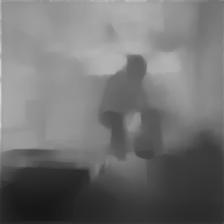

In [38]:
from PIL import Image
Image.open("/content/bgfg_output/depth_ol_bg001fg0011_fg_001.png.jpg")

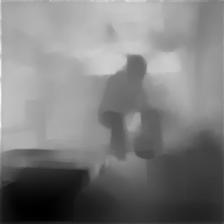

In [45]:
from PIL import Image
Image.open("/content/bgfg_output/depth_ol_bg001fg0011_fg_001.jpg")